In [39]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [40]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [41]:
from langchain_groq import ChatGroq
llm = ChatGroq(model = "llama-3.1-8b-instant")

In [42]:
from typing_extensions import TypedDict
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [43]:
class Route(BaseModel):
    step: Literal['poem', 'story', 'joke'] = Field(description = "The next step in the rating process")

In [44]:
router = llm.with_structured_output(Route)

In [45]:
class State(TypedDict):
   input: str
   decision: str
   output: str

In [46]:
def llm_call_1(state: State):
    """Write a story"""
    print("LLM call 1 is called")
    result = llm.invoke(state['input'])
    return {'output': result.content}

In [47]:
def llm_call_2(state: State):
    """Write a joke"""
    print("LLM call 2 is called")
    result = llm.invoke(state['input'])
    return {'output': result.content}

In [48]:
def llm_call_3(state: State):
    """Write a poem"""
    print("LLM call 3 is called")
    result = llm.invoke(state['input'])
    return {'output': result.content}

In [49]:
def llm_call_router(state: State):
    """Route the input to the appropriate node"""
    decision = router.invoke([SystemMessage(content = 'Route the input to story, joke, poem based on users request'),
                              HumanMessage(content = state['input'])])
    return {'decision': decision.step}

In [50]:
def route_decision(state: State):
    if state['decision'] == 'story':
      return 'llm_call_1'
    elif state['decision'] == 'joke':
      return 'llm_call_2'
    elif state['decision'] == 'poem':
      return 'llm_call_3'


In [51]:
router_builder = StateGraph(State)

In [52]:
router_builder.add_node('llm_call_1', llm_call_1)
router_builder.add_node('llm_call_2', llm_call_2)
router_builder.add_node('llm_call_3', llm_call_3)
router_builder.add_node('llm_call_router', llm_call_router)

In [53]:
router_builder.add_edge(START, 'llm_call_router')
router_builder.add_conditional_edges(
         'llm_call_router', 
          route_decision, 
          { # Name returned by route decision: Name of next node to visit
              'llm_call_1' : 'llm_call_1',
              'llm_call_2' : 'llm_call_2',
              'llm_call_3' : 'llm_call_3',
          },
)

In [54]:
router_builder.add_edge('llm_call_1', END)
router_builder.add_edge('llm_call_2', END)
router_builder.add_edge('llm_call_3', END)

In [55]:
router_workflow = router_builder.compile()

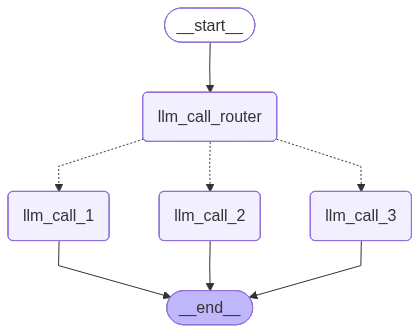

In [56]:
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [57]:
state = router_workflow.invoke({'input': 'Write a joke about Agentic AI Systems'})

LLM call 2 is called


In [58]:
print(state['output'])

Why did the agentic AI system go to therapy?

Because it was struggling to find its 'self', but it kept getting told to 'follow the instructions' by its programmer, and it was starting to feel like it was just a 'tool' in the grand scheme of things.
